# Compare different scenarios 

In [2]:
import matplotlib.pyplot as plt
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod_code
import model.base_inputs as inp
import experiments.analysis_poverty as msc
import plot.poverty as plt_sc
import imp
import numpy as np
import pickle
import copy
imp.reload(mod_code)
imp.reload(msc)

<module 'experiments.analysis_poverty' from '/home/twilliams/adaptation_abm/code/experiments/analysis_poverty.py'>

## Define scenarios 

In [6]:
# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
f = '../../outputs/2019_10_15_4/POM/100000_10reps/input_params_0.pkl'
inp_base = pickle.load(open(f, 'rb'))

# manually specify some variables (common to all scenarios)
inp_base['model']['T'] = 10 + inp_base['adaptation']['burnin_period']
inp_base['model']['n_agents'] = 300
inp_base['model']['exp_name'] = 'scenario_compare'
inp_base['agents']['adap_type'] = 'always'
inp_base['model']['seed'] = 0
# things not in the POM
inp_base['agents']['land_area_multiplier'] = 1
inp_base['adaptation']['cover_crop']['climate_dependence'] = True

# define some scenarios
## adaptation scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}

## SOM and wealth trajectories

In [7]:
# FUN THE MODEL
nreps = 10000
ncores = 40
mods = msc.multi_mod_run(nreps, inp_base, scenarios, ncores)

Text(-0.4, 1.15, 'Cover crop')

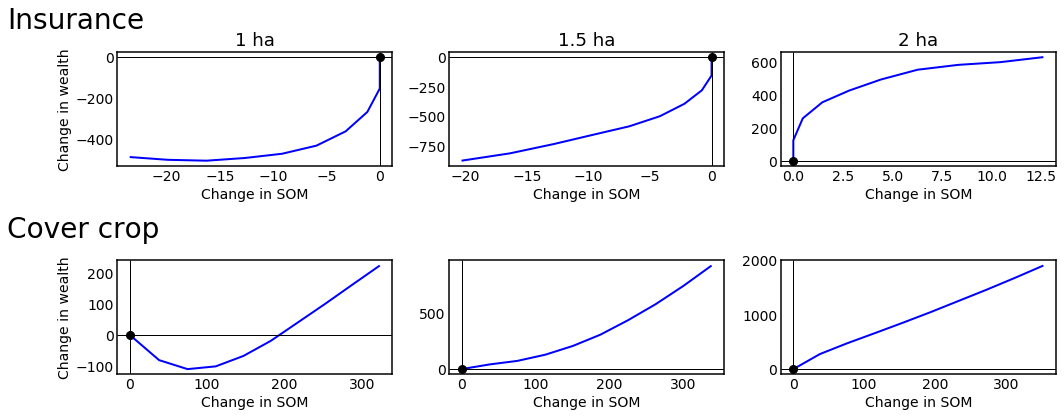

In [8]:
fig, axs = plt.subplots(2,3, figsize=(15,6))
pols = ['insurance', 'cover_crop']

for l, land_area in enumerate([1,1.5,2]):
    
    for p, pol in enumerate(pols):
        ax = axs[p,l]
        ## format the data
        areas = mods['baseline']['land_area'] == land_area
        som = np.swapaxes(mods[pol]['organic'] - mods['baseline']['organic'], 0, 1)
        som = np.mean(som[:,areas], axis=1)
        wealth = np.swapaxes(mods[pol]['wealth'] - mods['baseline']['wealth'], 0, 1)
        wealth = np.mean(wealth[:,areas], axis=1)

        # plot
        ax.plot(som, wealth, label=pol, lw=2)
        ax.plot(0,0, marker='o', color='k', markersize=8)

        ax.grid(False)
        ax.axhline(0, color='k', lw=1)
        ax.axvline(0, color='k', lw=1)
        
        if l == 0:
            ax.set_ylabel('Change in wealth')
        if p == 0:
            ax.set_title('{} ha'.format(land_area))
        ax.set_xlabel('Change in SOM')
    
axs[0,0].text(-0.4, 1.15, 'Insurance', transform=axs[0,0].transAxes, fontsize=28, va='bottom')
axs[1,0].text(-0.4, 1.15, 'Cover crop', transform=axs[1,0].transAxes, fontsize=28, va='bottom')

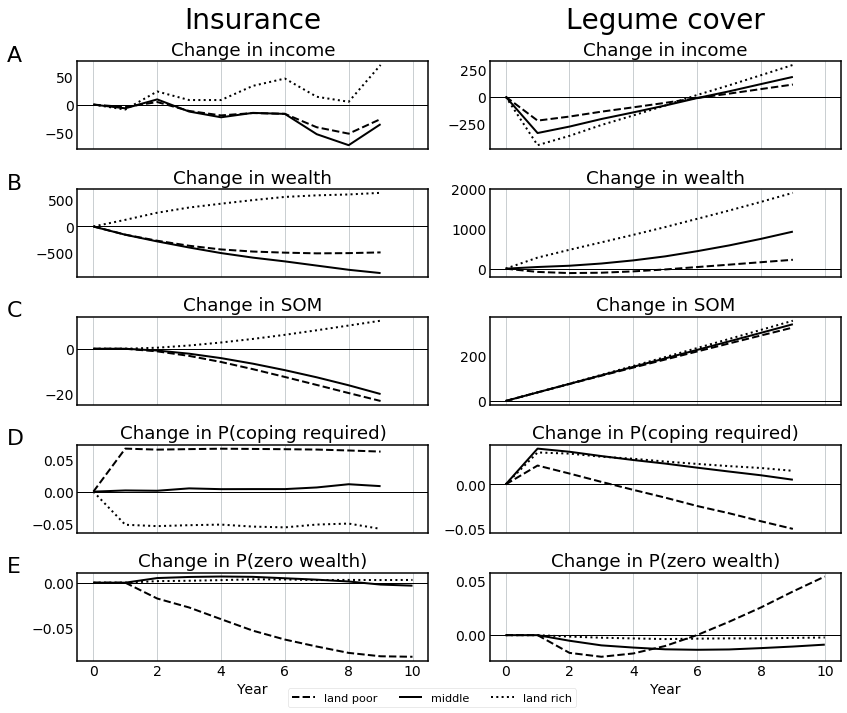

In [10]:
import string
fig, axs = plt.subplots(5,2, figsize=(12,10), sharex=True)
pols = ['insurance', 'cover_crop']
land_areas = [1, 1.5, 2]
land_areas_str = ['land poor','middle','land rich']
# ltys = ['-',':','-.']
ltys = ['--','-',':']

for o, outcome in enumerate(['income','wealth','organic','coping', 'zero_wealth']):
    for p, pol in enumerate(pols):
        ax = axs[o,p]
        for l, land_area in enumerate(land_areas):
            ## format the data
            areas = mods['baseline']['land_area'] == land_area
            if outcome != 'zero_wealth':
                data = np.swapaxes(mods[pol][outcome].astype(float) - mods['baseline'][outcome].astype(float), 0, 1)
                data = np.mean(data[:,areas], axis=1)
            else:
                data = np.swapaxes((mods[pol]['wealth']>0).astype(float) - (mods['baseline']['wealth']>0).astype(float), 0, 1)
                data = np.mean(data[:,areas], axis=1)
                
            # plot
            start = 11 if outcome in ['wealth','organic'] else 10
            ax.plot(data[start:], lw=2, label='{} ha'.format(land_area), ls=ltys[l], color='k')

            ax.axhline(0, color='k', lw=1, label='_nolegend_')
            if outcome == 'organic':
                titl = 'SOM'
            elif outcome == 'coping':
                titl = 'P(coping required)'
            elif outcome == 'zero_wealth':
                titl = 'P(zero wealth)'
            else:
                titl = outcome
            ax.set_title('Change in {}'.format(titl))
            ax.grid(False, axis='y')
    axs[o,0].text(-0.2,1,string.ascii_uppercase[o], transform=axs[o,0].transAxes, fontsize=22)
    
axs[-1,0].set_xlabel('Year')
axs[-1,1].set_xlabel('Year')
axs[0,0].text(0.5, 1.3, 'Insurance', va='bottom', ha='center', fontsize=28, transform=axs[0,0].transAxes)
axs[0,1].text(0.5, 1.3, 'Legume cover', va='bottom', ha='center', fontsize=28, transform=axs[0,1].transAxes)
lg = fig.legend([li for li in land_areas_str], ncol=3, bbox_to_anchor=[0.5, 0], loc='lower center')

## change in insurance price : effect on middle agent

# Changing parameters

In [30]:
scenarios = {
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}
policies = ['insurance','cover_crop']
nreps = 300
ncores = 40
inp_base['model']['T'] = 50 + inp_base['adaptation']['burnin_period']

### coping / climate

In [32]:
rain_mus = [0.4,0.5,0.6]
clrs = ['0.6','0.4','0.2']
results = {}
for m, mu in enumerate(rain_mus):
    inps = copy.deepcopy(inp_base)
    inps['climate']['rain_mu'] = mu
    results[mu] = msc.multi_mod_run(nreps, inps, scenarios, ncores)

Text(-0.1, 1.1, 'B')

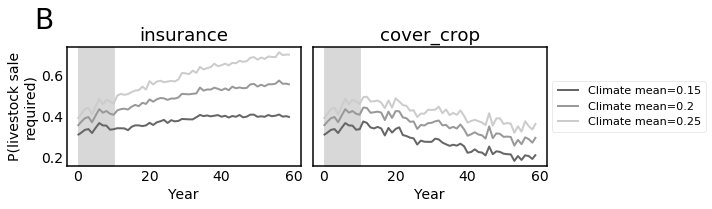

In [45]:
fig, axs = plt.subplots(1,2,figsize=(10,3), sharey=True)
c=-1
for mu, res in results.items():
    c+=1
    for p, pol in enumerate(policies):
        # calculate the relevant metric
        d = np.mean(res[pol]['coping'], axis=(0,2))
        axs[p].plot(d, label='Climate mean={}'.format(mu), color=clrs[c])

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(policies[a])
    l = ax.get_ylim()
    ax.fill_between([0,inp_base['adaptation']['burnin_period']], [l[0],l[0]], [l[1],l[1]], color='0.5', alpha=0.3)
    ax.set_ylim(l)
axs[1].legend(bbox_to_anchor=(1,0.5), loc='center left')
axs[0].set_ylabel('P(livestock sale\nrequired)')
axs[0].text(-0.1,1.1, 'B', transform=axs[0].transAxes, fontsize=28, va='bottom', ha='center')

In [40]:
rain_sigmas = [0.15,0.2,0.25]
clrs = ['0.4','0.6','0.8']
results = {}
for m, sig in enumerate(rain_sigmas):
    inps = copy.deepcopy(inp_base)
    inps['climate']['rain_sd'] = sig
    results[sig] = msc.multi_mod_run(nreps, inps, scenarios, ncores)

Text(-0.1, 1.1, 'C')

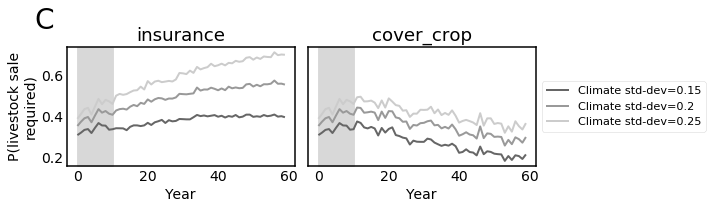

In [44]:
fig, axs = plt.subplots(1,2,figsize=(10,3), sharey=True)
c=-1
for mu, res in results.items():
    c+=1
    for p, pol in enumerate(policies):
        # calculate the relevant metric
        d = np.mean(res[pol]['coping'], axis=(0,2))
        axs[p].plot(d, label='Climate std-dev={}'.format(mu), color=clrs[c])

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(policies[a])
    l = ax.get_ylim()
    ax.fill_between([0,inp_base['adaptation']['burnin_period']], [l[0],l[0]], [l[1],l[1]], color='0.5', alpha=0.3)
    ax.set_ylim(l)
axs[1].legend(bbox_to_anchor=(1,0.5), loc='center left')
axs[0].set_ylabel('P(livestock sale\nrequired)')
axs[0].text(-0.1,1.1, 'C', transform=axs[0].transAxes, fontsize=28, va='bottom', ha='center')

### cash requirements

In [46]:
cashs = [4500,6000,7500]
clrs = ['0.6','0.4','0.2']
results = {}
for c, cash in enumerate(cashs):
    inps = copy.deepcopy(inp_base)
    inps['agents']['cash_req_mean'] = cash
    results[cash] = msc.multi_mod_run(nreps, inps, scenarios, ncores)

Text(-0.1, 1.1, 'A')

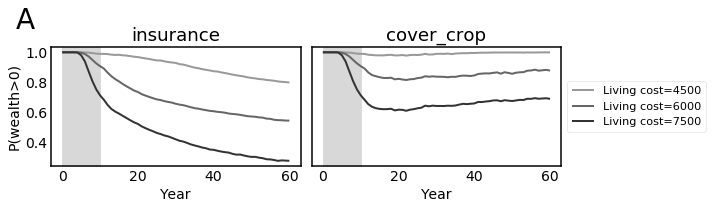

In [47]:
fig, axs = plt.subplots(1,2,figsize=(10,3), sharey=True)
c=0
for cash, res in results.items():
    for p, pol in enumerate(policies):
        # calculate the relevant metric
        d = np.mean(res[pol]['wealth']>0, axis=(0,2))
        axs[p].plot(d, label='Living cost={}'.format(cash), color=clrs[c])
        
    c+=1

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(policies[a])
    l = ax.get_ylim()
    ax.fill_between([0,inp_base['adaptation']['burnin_period']], [l[0],l[0]], [l[1],l[1]], color='0.5', alpha=0.3)
    ax.set_ylim(l)
axs[1].legend(bbox_to_anchor=(1,0.5), loc='center left')
axs[0].set_ylabel('P(wealth>0)')
axs[0].text(-0.1,1.1, 'A', transform=axs[0].transAxes, fontsize=28, va='bottom', ha='center')

### environment / yield

In [48]:
vals = [3000,4000,5000]
clrs = ['0.6','0.4','0.2']
results = {}
for v, val in enumerate(vals):
    inps = copy.deepcopy(inp_base)
    inps['land']['organic_N_min_init'] = val
    results[val] = msc.multi_mod_run(nreps, inps, scenarios, ncores)

Text(-0.1, 1.1, 'D')

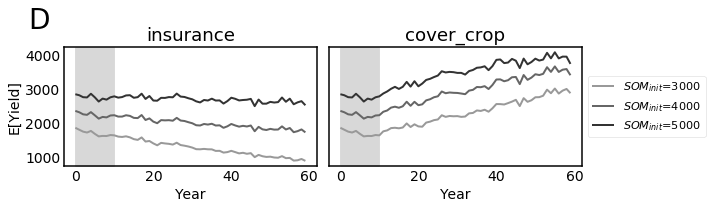

In [50]:
fig, axs = plt.subplots(1,2,figsize=(10,3), sharey=True)
c=0
for val, res in results.items():
    for p, pol in enumerate(policies):
        # calculate the relevant metric
        d = np.mean(res[pol]['yields'], axis=(0,2))
        axs[p].plot(d, label=r'$SOM_{ init}$'+'={}'.format(val), color=clrs[c])
        
    c+=1

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(policies[a])
    l = ax.get_ylim()
    ax.fill_between([0,inp_base['adaptation']['burnin_period']], [l[0],l[0]], [l[1],l[1]], color='0.5', alpha=0.3)
    ax.set_ylim(l)
axs[1].legend(bbox_to_anchor=(1,0.5), loc='center left')
axs[0].set_ylabel('E[Yield]')
axs[0].text(-0.1,1.1, 'D', transform=axs[0].transAxes, fontsize=28, va='bottom', ha='center')

### income risks

In [17]:
results = msc.multi_mod_run(10000, inp_base, scenarios, ncores)

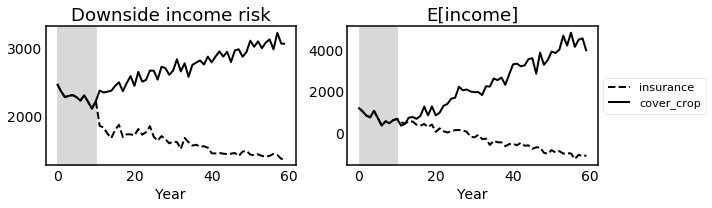

In [117]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
titles = ['Downside income risk','E[income]']
lss = ['--','-']
c=0
for p, pol in enumerate(policies):
    # calculate the relevant metrics
    d = res[pol]['income']
    plt_data = np.full(d.shape[1], np.nan)
    for t in range(d.shape[1]):
        di = d[:,t,:].flatten()
#             di += 10000
        di_mean = np.mean(di)
        # calculate downside risk (semivariance)
        plt_data[t] = np.std(di[di<=di_mean])#/ di_mean
    axs[0].plot(plt_data, label='pol', ls=lss[p], color='k')
    axs[1].plot(np.mean(d, axis=(0,2)), label=pol, color='k', ls=lss[p])

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(titles[a])
    l = ax.get_ylim()
    ax.fill_between([0,inp_base['adaptation']['burnin_period']], [l[0],l[0]], [l[1],l[1]], color='0.5', alpha=0.3)
    ax.set_ylim(l)
axs[1].legend(bbox_to_anchor=(1,0.5), loc='center left')
# axs[1].axhline(0, lw=0.5, color='k')
# axs[0].set_ylabel('Downside income risk')
# axs[0].text(-0.1,1.1, 'E', transform=axs[0].transAxes, fontsize=28, va='bottom', ha='center')

Distinguish agent types

In [18]:
res = results

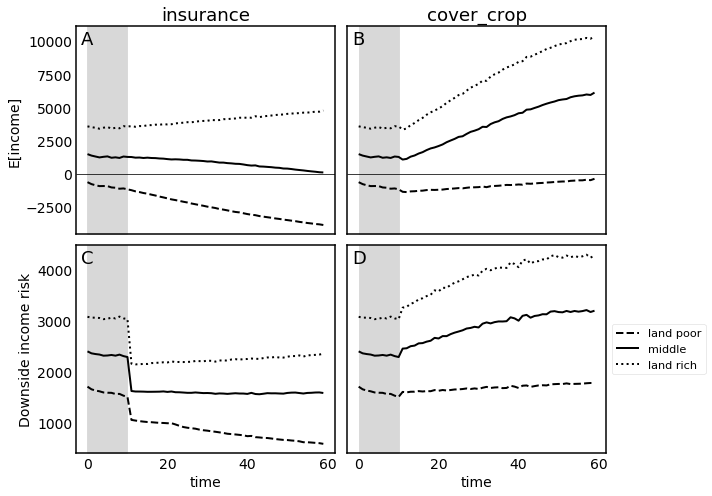

In [21]:
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey='row', sharex=True)
ax_flat = axs.flatten()
titles = ['Downside income risk','E[income]']
lss = ['--','-',':']
lands = [1,1.5,2]
land_str = ['land poor','middle','land rich']
import string
c=0
for p, pol in enumerate(policies):
    # calculate the relevant metrics
    d = np.swapaxes(res[pol]['income'],0,1)
    for l, land in enumerate(lands):
        ag = res[pol]['land_area'] == land
        d_exp = np.full(d.shape[0], np.nan)
        d_var = np.full(d.shape[0], np.nan)
        for t in range(d.shape[0]):
            di = d[t,ag]
            d_exp[t] = np.mean(di)
            d_var[t] = np.std(di[di<=d_exp[t]]) # semivariance (downside risk)
        axs[0,p].plot(d_exp, label=land_str[l], ls=lss[l], color='k')
        axs[1,p].plot(d_var, label=land_str[l], ls=lss[l], color='k')

for a, ax in enumerate(ax_flat):
    ax.grid(False)
    l = ax.get_ylim()
    ax.fill_between([0,inp_base['adaptation']['burnin_period']], [l[0],l[0]], [l[1],l[1]], color='0.5', alpha=0.3)
    ax.set_ylim(l)
    ax.text(0.02,0.98,string.ascii_uppercase[a], transform=ax.transAxes, fontsize=18, ha='left',va='top')
    
axs[0,0].set_ylabel('E[income]')
axs[1,0].set_ylabel('Downside income risk')
for ax in axs[1]:
    ax.set_xlabel('time')
axs[1,1].legend(bbox_to_anchor=(1,0.5), loc='center left')
for a, ax in enumerate(axs[0]):
    ax.set_title(policies[a])
    ax.axhline(0, lw=0.75, color='k')

# Climate / coping relationship

In [53]:
#### FOCUS ON INSURANCE
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}
ncores = 40
nreps = 10000
inp_base['model']['T'] = 100 + inp_base['adaptation']['burnin_period']

ins_percs = [0.02,0.05,0.1,0.2,0.3]
cols = np.linspace(0,0.95,len(ins_percs)).astype(str)
land_areas = [1,1.5,2]
res = {}
for ins in ins_percs:
    inps = copy.deepcopy(inp_base)
    inps['adaptation']['insurance']['climate_percentile'] = ins
    results = msc.multi_mod_run(nreps, inps, scenarios, ncores)
    res[ins] = results['insurance']

res_cc = results['cover_crop']

In [54]:
res_base = results['baseline']

In [55]:
## get the data
clim_bins = np.arange(0, 1.1, 0.05)
plot_vals = {}
plot_vals_cc = np.full((len(land_areas), clim_bins.shape[0]), np.nan)
plot_vals_base = np.full((len(land_areas), clim_bins.shape[0]), np.nan)

for ins in ins_percs:
    rain = res[ins]['climate']
    coping = res[ins]['coping']
    tmp = np.full((len(land_areas), clim_bins.shape[0]), np.nan)
    for l, land_area in enumerate(land_areas):
        ags = res[ins]['land_area'] == land_area
        ags_stack = np.array([ags for r in range(coping.shape[1])])
        coping2 = np.swapaxes(coping, 0,1)
        coping_ag = np.ma.masked_array(coping2, mask=ags_stack)
        coping_ag = np.swapaxes(coping_ag, 0,1)
        
        coping_ag_cc = np.swapaxes(np.ma.masked_array(np.swapaxes(res_cc['coping'], 0,1), mask=ags_stack), 0,1)
        coping_ag_base = np.swapaxes(np.ma.masked_array(np.swapaxes(res_base['coping'], 0,1), mask=ags_stack), 0,1)
        
        for r in range(1, clim_bins.shape[0]):
            mask = (rain > clim_bins[r-1]) * (rain <= clim_bins[r])
            tmp[l,r] = np.mean(coping_ag[mask,:])
            
            plot_vals_cc[l,r] = np.mean(coping_ag_cc[mask,:])
            plot_vals_base[l,r] = np.mean(coping_ag_base[mask,:])
        plot_vals[ins] = tmp

/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Warning: converting a masked element to nan.
/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Warning: converting a masked element to nan.
/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Warning: converting a masked element to nan.


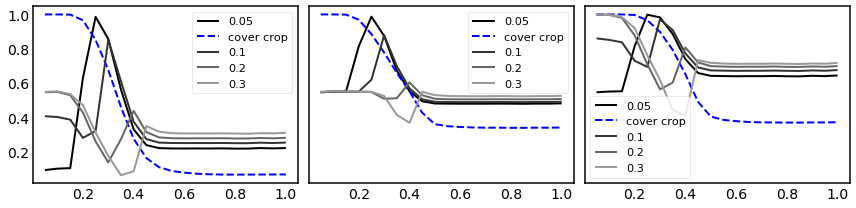

In [56]:
## plot
ins_percs_plot = ins_percs[1:]

fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
i = -1
for ins in ins_percs_plot:
    i += 1
    for l, land_area in enumerate(land_areas):
        ax = axs[l]
        ax.plot(clim_bins, plot_vals[ins][l], label=ins, color=cols[i])
        
        if i == 0:
            ax.plot(clim_bins, plot_vals_cc[l], label='cover crop', ls= '--')

for ax in axs:
    ax.grid(False)
    ax.legend()

### make a figure just for one type of agent

/home/twilliams/adaptation_abm/code/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  app.launch_new_instance()


Text(0, 0.5, 'P(livestock sale required)')

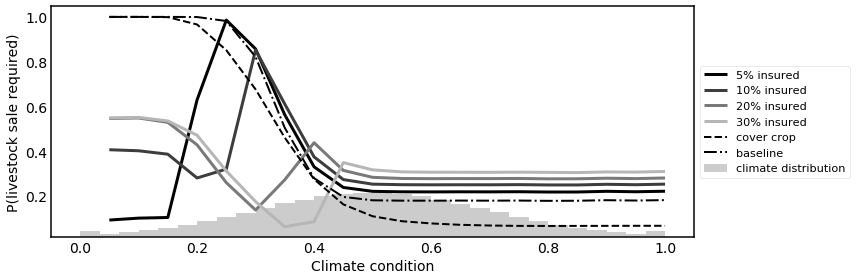

In [62]:
ins_percs_plot = ins_percs[1:]
l = 0

fig, ax = plt.subplots(1,1,figsize=(12,4))

i = -1
for ins in ins_percs_plot:
    i += 1
    ax.plot(clim_bins, plot_vals[ins][l], label='{}% insured'.format(int(ins*100)), color=cols[i], lw=3)

ax.plot(clim_bins, plot_vals_cc[l], label='cover crop', color='k', ls='--')
ax.plot(clim_bins, plot_vals_base[l], label='baseline', color='k', ls='-.')
    
lims = ax.get_ylim()
rain_flat = rain.flatten()
hists = np.histogram(rain_flat, bins=30, normed=True)
ax.bar(x=hists[1][:-1], height=hists[0]/10+lims[0], align='edge', width=hists[1][1]-hists[1][0], 
       color='0.8', label='climate distribution')
ax.set_ylim(lims)

ax.grid(False)
ax.legend(bbox_to_anchor=(1,0.5), loc='center left')
ax.set_xlabel('Climate condition')
ax.set_ylabel('P(livestock sale required)')

In [68]:
inp_base['climate']

{'rain_mu': 0.5, 'rain_sd': 0.2, 'shock_years': [30], 'shock_rain': 0.1}